# Mammal geometry leg inverse kinematics

Here we determine the inverse kinematics in position and force for
mammal geometry legs in 2D.  The 3D case is only slightly more 
complicated as the lateral angle is solved independently, at which
the remaining position is determined using exactly this procedure.

In [1]:
import math
import numpy as np
import sympy as sp

In [2]:
# This is conducted purely in 2d.  The geometry looks 
# like:
#
#     O               +y
#    /                ^
#   /  <--- femur     |
#  /
#  ---------P        -> +x
#
#    ^tibia
#
# Where O is the origin and P is the end effector point.

# Px, Py - position of end effector
# l1, l2 - length of femur and tibia
# theta1 - angle from vertical of upper leg
# theta2 - angle from vertical of lower leg
Px, Py, l1, l2, theta1, theta2 = \
    sp.symbols('Px Py l1 l2 theta1 theta2')

# This is a simple triangle.  We know the length of all 
# three sides, which means we can find all three angles.

# Use the law of cosines to find the tibia angle first.  
# Note: A practical implementation of this needs to 
# handle the limited domain of the relevant actuators 
# and other domain errors.
norm_PO_sq = Px * Px + Py * Py
norm_PO = sp.sqrt(norm_PO_sq)

cos_tibia_sub = l1 * l1 + l2 * l2 - norm_PO_sq

cos_tibia_inv = cos_tibia_sub / (2 * l1 * l2)
tibia_angle = sp.acos(cos_tibia_inv)

# Now do the femur.
cos_femur_sub = norm_PO_sq + l1 * l1 - l2 * l2
cos_femur_inv = cos_femur_sub / (2 * norm_PO * l1)
femur_angle = sp.acos(cos_femur_inv)

# Finally, convert these triangle angles into theta1 and 
# theta2, which are both measured relative to vertical, 
# with positive being a counterclockwise rotation.
etheta1 = {theta1: sp.atan2(Py, Px) + femur_angle + 
           sp.pi / 2}
ik = {
  'theta1': etheta1[theta1],
  'theta2': (theta1 - (sp.pi - tibia_angle)).subs(etheta1)
}

In [3]:
ik['theta1']

acos((Px**2 + Py**2 + l1**2 - l2**2)/(2*l1*sqrt(Px**2 + Py**2))) + atan2(Py, Px) + pi/2

In [4]:
ik['theta2']

acos((-Px**2 - Py**2 + l1**2 + l2**2)/(2*l1*l2)) + acos((Px**2 + Py**2 + l1**2 - l2**2)/(2*l1*sqrt(Px**2 + Py**2))) + atan2(Py, Px) - pi/2

# Torque

Now we will calculate the torque from an in-plane mammal geometry leg to 
achieve a given end-effector force.  As before, this only solves in 2 dimensions
as this is a sub-component of the 3 dimensional solution.

![Reference free body diagram](https://docs.google.com/drawings/d/e/2PACX-1vSUltzhAZBrtDqKxn8LvBXLhLOQatCL49l1j8gooBX2Ta413AleyVg1t0NhttvILkd1275p3pvYSvb6/pub?w=764&amp;h=723)

In [5]:
# Fx, Fy - force at end effector
# t1, t2 - torque on the upper and lower leg
# l1, l2 - length of upper and lower leg
# theta1 - angle from vertical of upper leg
# theta2 - angle from vertical of lower leg
Fx, Fy, t1, t2 = sp.symbols('Fx Fy t1 t2')
    
# We can trivially determine that F = I, so we'll just 
# use F for I everywhere.
    
# First, generate the equations for the top member.
    
# Torque as measured from the top pin point.
top_torque = sp.Eq(t1 + t2 - sp.cos(theta1) * l1 * Fx - 
                   sp.sin(theta1) * l1 * Fy, 0)

# The bottom force equation is identical to the top, so 
# provides no more degrees of freedom.

# Torque as measured from the bottom pin point.
bottom_torque = sp.Eq(t2 - sp.cos(theta2) * l2 * Fx + 
                      sp.sin(theta2) * l2 * Fy, 0)

# Now we have 2 equations and two unknowns.
torque_equations = sp.solve([top_torque, bottom_torque], 
                            [t1, t2])

In [6]:
torque_equations

{t1: Fx*l1*cos(theta1) - Fx*l2*cos(theta2) + Fy*l1*sin(theta1) + Fy*l2*sin(theta2),
 t2: l2*(Fx*cos(theta2) - Fy*sin(theta2))}

# Static torque required through a gait cycle

Now, given a sample leg design (femur and tibia length), determine the torque
required of both actuators through a single forward walking gait cycle.  This
results in the end effector moving along a line at a constant y position.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

plt.rcParams["animation.html"] = "jshtml"

In [8]:
def rotate(theta):
    c, s = math.cos(theta), math.sin(theta)
    return np.array(((c, -s), (s, c)))

class Gait:
    def __init__(self, height_off_ground, force=10, 
                 sl1=0.113, sl2=0.119):
        '''height_off_ground - gait offset from maximum 
                               extension (m)
        sl1 - femur length
        sl2 - tibia length'''
        self.height_off_ground = height_off_ground
        self.force = force
        self.sl1 = sl1
        self.sl2 = sl2

        self.ypos = -sl1 - sl2 + self.height_off_ground
        self.xmax = .98 * math.sqrt((sl1 + sl2) ** 2 - 
                                    self.ypos ** 2)
        
        # An optimal gait is one that runs from an x 
        # position of 0, until when the tibia is directly 
        # vertical.  The total torque required outside of
        # that range increases drastically.  Compute that 
        # range here.
        self.optimal_xrange = np.array(
            [0, math.sqrt(self.sl1**2 - 
                          (self.ypos + self.sl2)**2)])
        
    def do_ik(self, x, y):
        sPx = x  
        sPy = y

        exp = [
            (l1, self.sl1), 
            (l2, self.sl2), 
            (Px, sPx), 
            (Py, sPy),
        ]
        current = {key : sp.N(value.subs(exp)) 
                   for key, value in ik.items()}

        # Now do the forward kinematics to find where the 
        # joint and end-effector position are.

        stheta1, stheta2 = (current['theta1'], 
                            current['theta2'])

        p1 = rotate(stheta1).dot(
            np.array([[0], [-self.sl1]]))
        p2 = p1 + rotate(stheta2).dot(
            np.array([[0], [-self.sl2]]))

        return {
            'stheta1': stheta1,
            'stheta2': stheta2,
            'p1': p1,
            'p2': p2,
        }

    def find_torques(self, xpos):
        r = self.do_ik(xpos, self.ypos)
        exp = [(theta1, r['stheta1']),
               (theta2, r['stheta2']),
               (l1, self.sl1), (l2, self.sl2),
               (Fx, 0), (Fy, self.force)]
        torques = {key : sp.N(value.subs(exp)) 
                   for key, value in 
                   torque_equations.items()}
        return torques[t1], torques[t2]


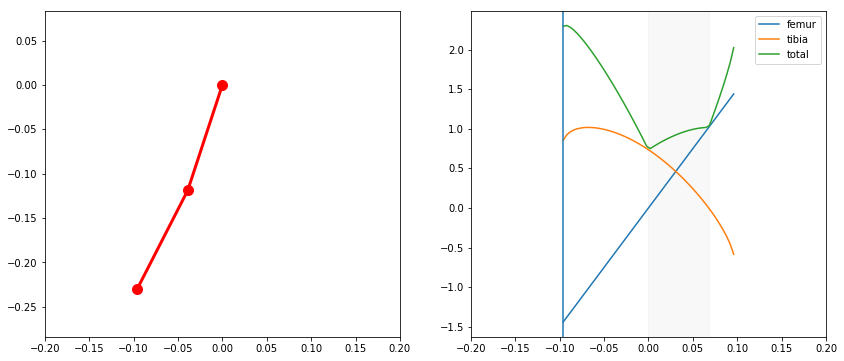

In [9]:
# Now generate our plots.
gait = Gait(0.02, sl1=0.5*0.25, sl2=0.5*0.25, force=15)

fig, [ax1, ax2] = plt.subplots(
    nrows=1, ncols=2, sharex=True, figsize=(14, 6))
ax1.axis('equal')
ax1.set_xlim((-0.20, 0.2))
ax1.set_ylim((-0.30, 0.1))

xspace = np.linspace(-gait.xmax, gait.xmax, 50)

torques = [gait.find_torques(x) for x in xspace]

# Plot the torques.
ax2.plot(xspace, [x[0] for x in torques], label='femur')
ax2.plot(xspace, [x[1] for x in torques], label='tibia')
ax2.plot(xspace, [abs(x[0]) + abs(x[1]) for x in torques],
         label='total')
xvline = ax2.axvline(x=0)
ax2.legend()

# Plot the leg configuration.
leg_line, = ax1.plot([], [], 'ro-', lw=3, markersize=10)
ax2.axvspan(gait.optimal_xrange[0],
            gait.optimal_xrange[1],
            color='gray', alpha=0.05)

def animate(i):
    r = gait.do_ik(xspace[i], gait.ypos)
    p1 = r['p1']
    p2 = r['p2']
    leg_line.set_data([0, p1[0], p2[0]], 
                      [0, p1[1], p2[1]])
    xvline.set_data([xspace[i], xspace[i]], [0, 1])
    return (leg_line,)

_ = animate(0)

In [10]:
# animation.FuncAnimation(fig, animate, frames=len(xspace), interval=60)

# Power consumption

Now, we will assume actuators which have a known current to torque ratio,
and a known resistance.  We will also assume that the primary power requirement
is the current required to hold the machine up, and that required for actual
forward motion.  This will allow us to calculate the instantaneous
and average power required during a gait cycle.

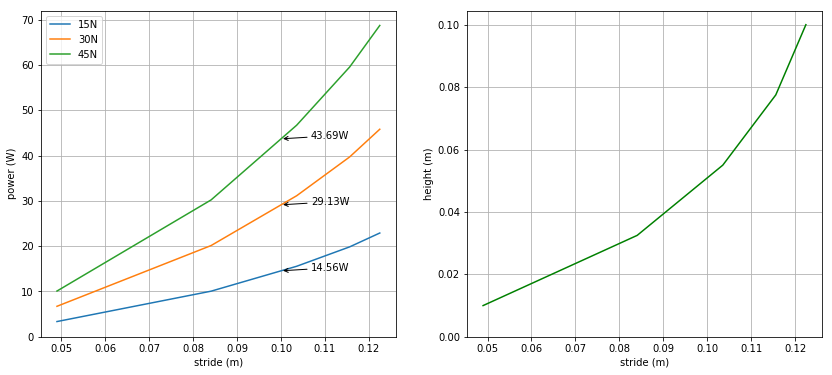

In [11]:
# Titan 6008 (0.0450 / 0.06)
# BE8108 (0.0875 / 0.10)
# 3508 gearbox (0.085 / 0.06)

femur_torque_per_amp = 0.0875
femur_resistance = 0.10
tibia_torque_per_amp = 0.0450 * 1.8  # belt reduction
tibia_resistance = 0.06

def calculate_power(femur_tibia_torque):
    femur_current_A = (femur_tibia_torque[0] / 
                       femur_torque_per_amp)
    femur_power = (femur_current_A ** 2 * 
                   femur_resistance)
    
    tibia_current_A = (femur_tibia_torque[1] / 
                       tibia_torque_per_amp)
    tibia_power = tibia_current_A ** 2 * tibia_resistance
    
    return femur_power, tibia_power

def get_gait_parameters(height, scale=1):
    total_length = .25 #  .232
    ratio = 0.5
    gait = Gait(height, force=15 * scale, 
                sl1=ratio * total_length, 
                sl2=(1.0 - ratio)*total_length)
    xrange = np.linspace(gait.optimal_xrange[0], 
                         gait.optimal_xrange[1])
    torques = [gait.find_torques(x) for x in xrange]

    powers = [calculate_power(v) for v in torques]
    avg_femur_power = (sum([i[0] for i in powers]) / 
                       len(powers))
    avg_tibia_power = (sum([i[1] for i in powers]) / 
                       len(powers))
    return ((avg_femur_power + avg_tibia_power) / scale, 
            (gait.optimal_xrange[1] - 
             gait.optimal_xrange[0])

# We will plot the average power required as a function of
# height, along with the maximum gait distance.
dspace = np.linspace(0.01, 0.10, 5)
fig, [ax, ax2] = plt.subplots(nrows=1, ncols=2, 
                              figsize=(14, 6))

ax.set_xlabel('stride (m)')
ax.set_ylabel('power (W)')

def make_plot(scale):
    results = [get_gait_parameters(x, scale=scale) 
               for x in dspace]
    strides = np.array([x[1] for x in results], 
                       dtype=np.float64)
    powers = np.array([x[0] for x in results], 
                      dtype=np.float64)
    line, = ax.plot(strides, powers, 
                    label='{:d}N'.format(15*scale))
    
    # Interpolate the power required for a stride of 0.1m 
    # and denote that on the plot.
    power_10cm = np.interp(0.1, strides, powers)
    ax.annotate('{:.2f}W'.format(power_10cm), 
                xy=(0.1, power_10cm),
                textcoords='offset pixels', 
                xytext=(30, 0),
                arrowprops=dict(arrowstyle="->"))
    return results

make_plot(1)
make_plot(2)
results = make_plot(3)

ax.legend(loc='upper left')
ax.set_ylim(bottom=0)
ax.grid()

# The height will be the same for everything, we we just 
# use the most recent one.
ax2.plot([x[1] for x in results], dspace, 'g')
ax2.set_ylim(bottom=0)
ax2.set_xlabel('stride (m)')
ax2.set_ylabel('height (m)')
_ = ax2.grid()